In [1]:
import filepath

In [2]:
import torch
import numpy as np
import sympy as sp
from abc import ABC
from typing import List, Dict, Tuple
from panda3d.core import VBase3
from panda3d.core import Vec3
from panda3d.core import Quat
from panda3d.core import invert

from panda3d_game.game_object import GameObject, PhysicsGameObject
from panda3d.core import TransformState
# 
from util.geometry import batch_transform
from art.basic import geom_frm_faces, create_cylinder_node, create_cylinder
from panda3d.core import GeomPrimitive
from panda3d.core import (
    Geom,
    GeomNode,
    GeomTriangles,
    GeomVertexData,
    GeomVertexFormat,
    GeomVertexWriter,
    GeomEnums, Vec3, LPoint3f
)    
from panda3d.core import GeomNode, NodePath, GeomVertexReader, BitMask32
from art.basic import uv_curve_surface, uv_curve_surface_lambda
from panda3d.bullet import (
    BulletWorld, BulletRigidBodyNode, BulletTriangleMesh, 
    BulletTriangleMeshShape, BulletDebugNode,
      BulletHingeConstraint, BulletGenericConstraint,
    BulletShape, BulletMinkowskiSumShape,BulletCylinderShape,
BulletConvexHullShape
)
# class RigidNodePath(NodePath):
#     def setPos(*args,**kwargs):
#         super().setPos(*args,**kwargs)
#         self.node().setTransform(self.getTransform())

In [3]:
def create_chain_shape(points:torch.Tensor) -> BulletShape:
    pass 

In [4]:
def create_convex_hull_shape(geoms):
    # 创建 BulletConvexHullShape
    convex_shape = BulletConvexHullShape()
    # if geoms is a single geom, TODO
    for geom in geoms:
        vdata = geom.getVertexData()
        vertex_reader = GeomVertexReader(vdata, 'vertex')
        while not vertex_reader.isAtEnd():
            vertex = vertex_reader.getData3()
            convex_shape.addPoint(Point3(vertex))
    return convex_shape

def create_convex_hull_shape_tr(geoms, transforms):
    # 创建 BulletConvexHullShape
    convex_shape = BulletConvexHullShape()
    # if geoms is a single geom, TODO
    for i in range(len(geoms)):
    # for geom in geoms:
        geom = geoms[i]
        transform =transforms[i]
        vdata = geom.getVertexData()
        vertex_reader = GeomVertexReader(vdata, 'vertex')
        while not vertex_reader.isAtEnd():
            vertex = vertex_reader.getData3()
            vertex = transform.xformPoint(vertex)
            convex_shape.addPoint(Point3(vertex))
    return convex_shape
def nodePathFrmPos(
    parent:NodePath, nodes:Dict["str", Tuple[float,float,float]], node_name_prefix=""
) -> Dict["str", NodePath]:
    # a single node path specifying a position
    ret = {}
    for key in nodes:
        node_path = parent.attachNewNode("{}{}".format(node_name_prefix, key))
        pos = nodes[key]
        node_path.setPos(*pos)
        ret[key] = node_path
    return ret

class PowerGen(ABC):
    def power(self) -> sp.Expr:
        pass
    pass

class ElectricityAppliance(ABC):

    def set_supply(self, supply):
        pass

    def get_voltage(self) -> sp.Expr:
        pass

    @property
    def voltage(self) -> sp.Expr:
        return self.get_voltage
        
    @property
    def current(self) -> sp.Expr:
        pass
    pass

class PowerSupplySystem(ABC,GameObject):
    
    
    @property
    def inputs(self) -> List[PowerGen]:
        pass

    def add_input(self, powergen:PowerGen):
        pass

    def add_output(self, output:ElectricityAppliance):
        pass

    def update(self, task):
        # TODO: power(out) = sum u*i
        # power in = sum p
        # delta E = (power in - power out)dt 
        return super().update(task)
    pass

class Thruster(ABC,GameObject):
    @property
    def thrust_val(self) -> sp.Expr:
        pass

    @property
    def thrust_dire(self) -> torch.Tensor:
        # thrust direction
        # fixed for non vector thrust
        pass

    @property
    def thrust(self) -> torch.Tensor:
        pass
        
    pass

class MagicThruster(Thruster):
    def __init__(self):
        # thrust is magically produced 
        # does not has limit 
        # does not rely on any machanism
        # does not consume fuels
        # used for testing
        super().__init__()
        self._thrust = 0

        

    @property
    def thrust_val(self) -> sp.Expr:
        return self._thrust_val


    @property
    def thrust(self) -> torch.Tensor:  # in game scale, without unit 
        pass
        
class HallEffectThruster(Thruster, ElectricityAppliance):
    def get_current(self):
        pass
    pass
    
class ThrusterSet:

    @property
    def thrusters(self) -> List[Thruster]:
        pass
    pass


class WheelPair(PhysicsGameObject):
    def setColor(self, rgba):
        self.wheel1_np.setColor(rgba)
        self.wheel2_np.setColor(rgba)

    @property
    def mainPath(self):
        return self.rigid_np
    def __init__(
        self, 
        radius:float, 
        thickness:float,
        single_mass:float,
        loc_rolling_bearings, name: str
    ):
        """
        :param radius:
        :param thickness:
        :param loc_rolling_bearings: location and also direction of 2 rolling rears, [(x,y,z), (x,y,z)]
        """
        PhysicsGameObject.__init__(self)
        self.name = "Wheel.{}".format(name)
        self.radius = float(radius)
        self.thickness = float(thickness)
        self.single_mass = float(single_mass)
        self.rigid_node = BulletRigidBodyNode(f'{self.name}.rigid')
        self.rigid_node.setMass(2*self.single_mass)
        self.wheel1 = create_cylinder_node(
            name=f"{self.name}.1",
            radius=self.radius,
            height=self.thickness,
            lon_res=8,
        )
        self.wheel2 = create_cylinder_node(
            name=f"{self.name}.2",
            radius=self.radius,
            height=self.thickness,
            lon_res=8,
        )
        cylinder_geom = create_cylinder(
            name="tmp",
            radius=self.radius,
            height=self.thickness,
            lon_res=8,
            with_bot=False,
            with_top=False
        )
        # cylinder_shape = BulletCylinderShape(radius=self.radius, height=self.thickness,up=1)
        # cylinder_shape = getCylinderShape(radius=self.radius, height=self.thickness, lon_res=8)
        self.wheel1_np = NodePath(self.wheel1)
        # print(self.wheel1_np.getGeom(0))
        self.wheel2_np = NodePath(self.wheel2)
        self.wheel1_np.lookAt(*(loc_rolling_bearings[0]))
        self.wheel1_np.setPos(*(loc_rolling_bearings[0]))
        self.wheel2_np.lookAt(*(loc_rolling_bearings[1]))
        self.wheel2_np.setPos(*(loc_rolling_bearings[1]))
        convec_hull_wheel1 = create_convex_hull_shape_tr(
            # geoms=[self.wheel1.getGeom(0)],
            geoms=[cylinder_geom],
            transforms=[self.wheel1_np.getTransform().getMat()]
        )
        convec_hull_wheel2 = create_convex_hull_shape_tr(
            # geoms=[self.wheel2.getGeom(0)],
            geoms=[cylinder_geom],
            transforms=[self.wheel2_np.getTransform().getMat()]
        )
        # cylinder1 = BulletCylinderShape(
        # compound_shape = 
        self.rigid_node.addShape(convec_hull_wheel1)
        self.rigid_node.addShape(convec_hull_wheel2)
        # self.rigid_node.addShape(cylinder_shape, self.wheel1_np.getTransform())
        # self.rigid_node.addShape(cylinder_shape, self.wheel2_np.getTransform())
        # self.rigid_node.addShape(cylinder_shape, TransformState.makePos(Point3(10,0,0)))
        # self.rigid_node.addShape(cylinder_shape, self.wheel2_np.getTransform())
        self.rigid_np = NodePath(self.rigid_node)
        self.wheel1_np.reparent_to(self.rigid_np)
        self.wheel2_np.reparent_to(self.rigid_np)
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)
        self.rigid_node.setFriction(0)

class FlyWheelFrame(PhysicsGameObject):
    
    def __init__(self, edge_length, edge_width, name:str, mass=1):
        PhysicsGameObject.__init__(self)
        self.name = "Frame.{}".format(name)
        self.edge_length = float(edge_length)
        self.edge_width = float(edge_width)
        self.mass = float(mass)
        self.geom_node = GeomNode(self.name)
        trape_edge = torch.Tensor([
            [-edge_length / 2, edge_length / 2, -edge_length / 2],
            [edge_length / 2, edge_length / 2, -edge_length / 2],
            [edge_length / 2 - edge_width, edge_length / 2 - edge_width, -edge_length / 2],
            [-edge_length / 2 + edge_width, edge_length / 2 - edge_width, -edge_length / 2]
        ])
        recta_edge = torch.Tensor([
            [-edge_length / 2 + edge_width, edge_length / 2 - edge_width, -edge_length / 2],
            [edge_length / 2 - edge_width, edge_length / 2 - edge_width, -edge_length / 2],
            [edge_length / 2 - edge_width, edge_length / 2 - edge_width, -edge_length / 2 + edge_width],
            [-edge_length / 2 + edge_width, edge_length / 2 - edge_width, -edge_length / 2 + edge_width],
        ])
        # first rotation
        transforms_1edge_to_1surf = [
                # xy
                torch.Tensor([
                    [0, 1, 0],
                    [-1, 0, 0],
                    [0, 0, 1]
                ]),
                torch.Tensor([
                    [-1, 0, 0],
                    [0, -1, 0],
                    [0, 0, 1]
                ]),
                torch.Tensor([
                    [0, -1, 0],
                    [1, 0, 0],
                    [0, 0, 1]
                ]),
                torch.Tensor([
                    [1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]
                ])
            ]
        transforms_1surf_to_cube = [
                torch.Tensor([
                    [1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 1]
                ]),
                # xz
                torch.Tensor([
                    [0, 0, 1],
                    [0, 1, 0],
                    [-1, 0, 0]
                ]),
                torch.Tensor([
                    [-1, 0, 0],
                    [0, 1, 0],
                    [0, 0, -1]
                ]),
                torch.Tensor([
                    [0, 0, -1],
                    [0, 1, 0],
                    [1, 0, 0]
                ]),
                # yz
                torch.Tensor([
                    [1, 0, 0],
                    [0, 0, -1],
                    [0, 1, 0]
                ]),
                torch.Tensor([
                    [1, 0, 0],
                    [0, 0, 1],
                    [0, -1, 0]
                ])
            ]
        trape_surf = batch_transform(
            [trape_edge], transforms_1edge_to_1surf)
        trape_cube = batch_transform(
            trape_surf, transforms_1surf_to_cube)
        recta_surf = batch_transform(
            [recta_edge], transforms_1edge_to_1surf)
        recta_cube = batch_transform(
            recta_surf, transforms_1surf_to_cube)
        self.faces = trape_cube + recta_cube
        self.geom = geom_frm_faces(name=self.name, faces=self.faces)
        self.geom_node.addGeom(self.geom)
        self.geom_np = NodePath(self.geom_node)
        self.rigid_node = BulletRigidBodyNode(self.name)
        self.rigid_node.setMass(self.mass)
        # FIXME: use minkowski sum
        for i in range(24):
            # print(i)
            convex_shape = BulletConvexHullShape()
            for point in trape_cube[i]:
                convex_shape.addPoint(Vec3(*point))
            for point in recta_cube[i]:
                convex_shape.addPoint(Vec3(*point))
            self.rigid_node.addShape(convex_shape)
        self.rigid_np = NodePath(self.rigid_node)
        self.geom_np.reparentTo(self.rigid_np)
        # marker nodes
        self.center_np = self.mainPath.attachNewNode("{}.center".format(self.name))
        self.center_np.setPos(0,0,0)
        # marker nodes for bearings
        self.bearings_np:Dict[str, NodePath] = nodePathFrmPos(
            self.mainPath,
            {
                "x+":(self.edge_length / 2 - self.edge_width, 0, 0),
                "x-":(-self.edge_length / 2 + self.edge_width, 0, 0),
                "y+":(0, self.edge_length / 2 - self.edge_width, 0),
                "y-":(0, -self.edge_length / 2 + self.edge_width, 0),
                "z+":(0, 0, self.edge_length / 2 - self.edge_width),
                "z-":(0, 0, -self.edge_length / 2 + self.edge_width)
            },
            node_name_prefix="{}.".format(self.name)
        )
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)
        # print(self.rolling_bearings())
    
    def rolling_bearings(self):
        return {
            key: self.bearings_np[key].getPos() - self.mainPath.getPos()
            for key in self.bearings_np
        }

class FlyWheel(PhysicsGameObject):

    def setLinearVelocity(self, v):
        for c in self.children:
            c.rigid_node.setLinearVelocity(v)
    # rigid_body.setAngularVelocity(angular_velocity)
    @property
    def mainPath(self):
        return self.frame.mainPath

    def reparentTo(self, other):
        for child in self.children:
            child.reparentTo(other)
        # self.mainPath.reparentTo(other)

    def toBulletWorld(self, world):
        for child in self.children:
            child.toBulletWorld(world)
        # self.mainPath
        for constraint in self.constraints:
            world.attachConstraint(constraint)

    def setActive(self,state):
        for c in self.children:
            c.rigid_node.setActive(state)
            print(c, c.rigid_node.isActive())

    
    def __init__(
        self,
        length,
        frame_width,
        frame_mass,
        single_wheel_mass,
        name:str
    ):
        PhysicsGameObject.__init__(self)
        self.length = float(length)
        self.frame_width = float(frame_width)
        self.frame_mass = float(frame_mass)
        self.single_wheel_mass = float(single_wheel_mass)
        self.wheel_radius = float(length / 2 - frame_width-0.1)
        self.name = "FlyWheel.{}".format(name)
        self.frame = FlyWheelFrame(
            name=self.name,
            edge_length=self.length,
            edge_width=self.frame_width,
            mass=self.single_wheel_mass
        )
        bearings_loc = self.frame.rolling_bearings()
        self.bearing_x = WheelPair(
            self.wheel_radius,
            self.frame_width,
            self.single_wheel_mass,
            [bearings_loc["x+"], bearings_loc["x-"]],
            f"{self.name}.x"
        )
        self.bearing_x.setColor((1,0,0,1))
        self.bearing_y = WheelPair(
            self.wheel_radius,
            self.frame_width,
            self.single_wheel_mass,
            [bearings_loc["y+"], bearings_loc["y-"]],
            f"{self.name}.y"
        )
        self.bearing_z = WheelPair(
            self.wheel_radius,
            self.frame_width,
            self.single_wheel_mass,
            [bearings_loc["z+"], bearings_loc["z-"]],
            f"{self.name}.z"
        )
        self.children = [
            self.frame, 
            self.bearing_x,
            self.bearing_y, 
            self.bearing_z
        ]
        # self.bearing_x.reparentTo(self.mainPath)
        # self.bearing_y.reparentTo(self.mainPath)
        # self.bearing_z.reparentTo(self.mainPath) #FIXME
        self.hinge_x = BulletHingeConstraint(
            self.frame.rigid_node, self.bearing_x.rigid_node, 
            LPoint3f(0, 0, 0),LPoint3f(0, 0, 0),
            Vec3(1,0,0),Vec3(1,0,0)
        )
        self.hinge_y = BulletHingeConstraint(
            self.frame.rigid_node, self.bearing_y.rigid_node,
            LPoint3f(0, 0, 0), LPoint3f(0, 0, 0), 
            Vec3(0,1,0), Vec3(0,1,0),
        )
        self.hinge_z = BulletHingeConstraint(
            self.frame.rigid_node, self.bearing_z.rigid_node, 
            LPoint3f(0, 0, 0), LPoint3f(0, 0, 0), 
            Vec3(0,0,1), Vec3(0,0,1),
        )
        self.constraints = [
            self.hinge_x, 
            self.hinge_y, 
            self.hinge_z
        ]
        for c in self.constraints:
            c.setDebugDrawSize(40.0)
        self.rigid_node = self.frame.rigid_node
        self._torque = torch.Tensor([0,0,0])
        # self.hinge_x_axis_b = self.hinge_x.getAxisB()
        # self.world_hinge_x_axis_b = self.bearing_x.getQuat().xform(self.hinge_x_axis_b)
        # print(self.world_hinge_x_axis_b)

    # def get_angular_pos(self):
    #     pass

    def apply_torque_on_axis(self, axis=0, torque=1):
        if axis==0:
            self.bearing_x.rigid_node.applyTorque((1,0,0))
        pass

    def set_torque_on_axis(self, axis, torque):
        torque = float(torque)
        self._torque[axis] = torquebody.applyTorque(Point3(0, 0, 5))

    def set_torque(self, torque):
        self._torque = torque
        # joint
    # def apply_torque(self, torque):
    #     self.bearing_x.rigid_node
        
class Shuttle(GameObject):
    pass

class Obj000(Shuttle, PhysicsGameObject):

    def reparentTo(self, other):
        # FIMXE: add to child list
        for child in self.children:
            child.reparentTo(other)
    @property
    def mainPath(self):
        # return self.node_path
        return self.shell.mainPath

    def toBulletWorld(self, bulletWorld):
        # self.shell.toBulletWorld(bulletWorld)
        for c in self.children:
            c.toBulletWorld(bulletWorld)
        for c in self.constraints:
            bulletWorld.attachConstraint(c)
        # self.flywheel.toBulletWorld(bulletWorld) FIXME
        # bulletWorld.attachConstraint(self.fixed_constraint)
    
    def __init__(self, unit, name):
        PhysicsGameObject.__init__(self)
        self.unit = unit
        self.name = name
        # self.node_path = NodePath()
        self.shell_radius_minor = 1 * meter
        self.shell_radius_major = 100 * meter
        self.frame_thickness = 0.1 * meter
        self.keel_thickness = 1 * meter
        self.shell = Obj001_shell(
            r1=self.shell_radius_minor / self.unit["length"],
            r2=self.shell_radius_major / self.unit["length"],
            a=0.02*(self.unit["length"]/meter),
            frame_thickness=self.frame_thickness / self.unit["length"],
            keel_thickness=self.keel_thickness / self.unit["length"],
            name=self.name
        )
        # self.shell.reparentTo(self.node_path)
        self.fly_wheel_length = 30 * meter 
        self.fly_wheel_width = 3 * meter
        self.thrusterSetTop = None
        self.thrusterSetBot = None
        self.flywheel = FlyWheel(
            name=self.name,
            length=self.fly_wheel_length / self.unit["length"],
            frame_width=self.fly_wheel_width / self.unit["length"],
            frame_mass=1,single_wheel_mass=1,
        )
        # self.flywheel.reparentTo(self.mainPath)
        frame_a = TransformState.makePos((0,0,0))
        frame_b = TransformState.makePos((0,0,0))
        self.fixed_constraint = BulletGenericConstraint(
            self.flywheel.rigid_node, self.shell.rigid_node, 
            # Vec3(0, 0, 0)
            frame_a, frame_b,True
            # LPoint3f(0,0,0), # LPoint3f(0,0,0)
        )
        # Disable all linear movement along X, Y, Z axes
        linear_limit = 0,0
        self.fixed_constraint.setLinearLimit(0, *linear_limit)  # x
        self.fixed_constraint.setLinearLimit(1, *linear_limit)  # y
        self.fixed_constraint.setLinearLimit(2, *linear_limit)  # z
        # Disable all angular rotation around X, Y, Z axes
        angular_limit = 0,0
        self.fixed_constraint.setAngularLimit(0, *angular_limit)  # rotation around x
        self.fixed_constraint.setAngularLimit(1, *angular_limit)  # rotation around y
        self.fixed_constraint.setAngularLimit(2, *angular_limit) 
        self.constraints = [
            self.fixed_constraint
        ]
        self.children = [self.shell, self.flywheel]

    def setFlyWheelTorque(self):
        pass

    def getVelocity(self):
        pass

    def getAngularVelocity(self):
        pass

    def getPos(self):
        pass
        

# class FixedConstraint(BulletGenericConstraint):
#     def __init__(self,

In [5]:
a = torch.Tensor([1,2,3])
b = torch.Tensor([1,2,3])
Vec3(*a)

LVector3f(1, 2, 3)

In [6]:

from panda3d.bullet import BulletWorld, BulletRigidBodyNode,  BulletDebugNode
class Obj001_shell(PhysicsGameObject):
    def setScale(self, scale):
        # FIXME
        # self.geom_np.setScale(scale)
        self.rigid_np.setScale(scale)

    def setColor(self, r,g,b,a):
        self.geom_np.setColor(r,g,b,a)

    def setTexture(self,t):
        self.geom_np.set_texture(t)
        
    def __init__(self, r1, r2, a, frame_thickness, keel_thickness, name, mass=1):
        # print(r1, type(r1),float(r1))
        # FIXME: use sympy
        r1 = float(r1)
        r2 = float(r2)
        a = float(a)
        mass = float(mass)
        frame_thickness = float(frame_thickness)
        keel_thickness = float(keel_thickness)
        super().__init__()
        assert r2 >= r1
        self.r1 = r1
        self.r2 = r2
        self.a = a
        self.mass = mass
        self.frame_thickness = frame_thickness
        self.keel_thickness = keel_thickness
        self.name = "Shell.{}".format(name)
        self.geom_node = GeomNode(self.name)
        self.rigid_node = BulletRigidBodyNode(f"{self.name}.rigid")
        # 2 paraboloids in column coord
        self.n_step_shell = 6
        theta = torch.arange(start=0, end=2 * np.pi, step=np.pi/self.n_step_shell)
        step = (r2 - r1) / 6
        rho = torch.arange(start=r1, end=r2 + step, step=step)
        z_2_shift = self.a * self.r2 ** 2
        self.geom_c1 = uv_curve_surface_lambda(
            f"{self.name}.1",
            u=theta,v=rho,
            is_u_loop=True, is_v_loop=False,
            x_uv=lambda _theta, _rho: a * _rho ** 2 - z_2_shift,
            y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
            z_uv=lambda _theta, _rho: _rho * np.sin(-_theta),
            # FIXME geom node
        )
        self.geom_c2 = uv_curve_surface_lambda(
            f"{self.name}.2",
            u=theta,v=rho,
            is_u_loop=True, is_v_loop=False,
            x_uv=lambda _theta, _rho: -  a * _rho ** 2 + z_2_shift,
            y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
            z_uv=lambda _theta, _rho: _rho * np.sin(_theta),
            # FIXME geom node
        )
        self.geom_node.addGeom(self.geom_c1)
        self.geom_node.addGeom(self.geom_c2)
        self.geom_np = NodePath(self.geom_node)
        # convec_hull_shape = create_convex_hull_shape(
        #     geoms=[self.geom_c1,self.geom_c2]
        # )
        self.n_step_frame = 8
        step = (r2 - r1) / self.n_step_frame
        rho = torch.arange(start=r1, end=r2+step, step=step)[1:-1]
        z_2_shift = a * r2 ** 2
        pos_x = a * rho ** 2 - z_2_shift
        self.rigid_node.setMass(self.mass)
        for i in range(len(rho)):
            pos_xi = pos_x[i]
            ri = rho[i]
            shape = BulletCylinderShape(radius=ri, height=self.frame_thickness, up=0)
            self.rigid_node.addShape(shape, TransformState.makePos((pos_xi,0,0)))
            self.rigid_node.addShape(shape, TransformState.makePos((-pos_xi,0,0)))
            
        
        # self.rigid_node.addShape(convec_hull_shape)
        
        # self.rigid_node.setCollisionFlag(BulletRigidBodyNode.CF_NO_CONTACT_RESPONSE)
        # self.rigid_node.setIntoCollideMask(BitMask32(0))
        # self.rigid_node.setFromCollideMask(BitMask32(0))
        self.rigid_node.setRestitution(0)
        self.rigid_node.setFriction(0)
        
        self.rigid_np = NodePath(self.rigid_node)
        self.rigid_np.setCollideMask(BitMask32.bit(0))
        self.geom_np.reparentTo(self.rigid_np)
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)
    # def reparentTo

        
        

In [7]:
import sys
import filepath
import pdb
from demos.starlight_qt import *
import torch
from qpanda3d import QControl # FIXME
from panda3d_game.app import ControlShowBase, UniversalGravitySpace
from panda3d.bullet import BulletRigidBodyNode
from panda3d.bullet import BulletSphereShape, BulletCylinderShape

In [8]:
from panda3d.core import DirectionalLight, Vec3, PointLight
from sympy.physics.units import (
    kilometer, meter,centimeter,
    gram, kilogram, tonne,
    newton, second
)
from demos.ball_room import MassedBall,tmoon
from art.basic import create_sphere_node

class Test(PhysicsGameObject):
    def __init__(self):
        
        self.rigid_node = BulletRigidBodyNode('vv')
        self.rigid_node.set_mass(1)
        
        shape = BulletSphereShape(1)
        self.rigid_node.add_shape(shape)
        self.geom_node = create_sphere_node('vv', lat_res=24,lon_res=24)
        self.rigid_np = NodePath(self.rigid_node)
        self.geom_np = NodePath(self.geom_node)
        self.geom_np.reparentTo(self.rigid_np)
        self.geom_np.setTexture(tmoon)
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)

def getCylinderShape(radius, height, lon_res):
    axis_coord_theta = torch.arange(0,1,step=1/lon_res) * 2 * np.pi
    # axis_coord_phi = torch.arange(0,1,step=1/lat_res) * 2 * np.pi
    # fixme: set lat res to 1
    # axis_coord_z = torch.arange(0,1,step=1/lat_res)
    convex_shape = BulletConvexHullShape()
    axis_coord_y = torch.Tensor([height,0])
    vertex_coord_theta, vertex_coord_y = torch.meshgrid(
        axis_coord_theta,axis_coord_y,
        indexing='ij'
    )
    # vertex_coord_r = torch.cos(vertex_coord_phi)
    vertex_coord_r = radius
    # vertex_coord_z = torch.sin(vertex_coord_phi)
    # vertex_coord_z = 
    vertex_coord_x = torch.cos(vertex_coord_theta) * vertex_coord_r
    vertex_coord_z = torch.sin(vertex_coord_theta) * vertex_coord_r
    
    vertex_coord_xyz = torch.concat([
        vertex_coord_x.unsqueeze(-1),
        vertex_coord_y.unsqueeze(-1),
        vertex_coord_z.unsqueeze(-1)
    ], dim=-1)
    for col in range(2):
        for row in range(lon_res):
            vertex = tuple(vertex_coord_xyz[row,col].numpy())
            
            convex_shape.addPoint(Point3(vertex))
    return convex_shape
    
class Test2(PhysicsGameObject):

    def __init__(self):
        self.rigid_node = BulletRigidBodyNode('vv')
        self.rigid_node.set_mass(1)
        # shape = BulletCylinderShape(radius=4,height=1)
        shape = getCylinderShape(4,1,lon_res=8)
        self.rigid_node.add_shape(shape,TransformState.makePos(Point3(0,1,0)))
        self.rigid_node.add_shape(shape,TransformState.makePos(Point3(0,-1,0)))
        self.rigid_node.setLinearSleepThreshold(0)
        self.rigid_node.setAngularSleepThreshold(0)
        self.rigid_np = NodePath(self.rigid_node)


class ShipScene(
    StarScene, 
    UniversalGravitySpace, 
    QControl
    # ControlShowBase
):
    def __init__(self):
        StarScene.__init__(self)
        unit = {
            "mass" : tonne,
            "length" : 10*meter,
            "time": 1 * second,
            # "force" : sp.Number(1e3) * newton
        }
        G_game = 0.001
        UniversalGravitySpace.__init__(self, unit, G_game)
        QControl.__init__(self)
        # self.planet1 = MassedBall(
        #     name="planet1",
        #     radius=10*meter,
        #     mass=1*tonne,
        #     units=self.unit
        # )
        # self.planet1.reparentTo(self.render)
        # self.planet1.set_texture(tmoon)
        # mass = self.planet1.rigid_node
        # mass.setLinearSleepThreshold(0)
        # mass.setAngularSleepThreshold(0)
        # self.mass = mass
        # self.planet1.toBulletWorld(self.bullet_world)
        
        # self.shell = Obj001_shell(r1=1,r2=100,a=0.02,name='test')
        # self.shell.setScale(0.01)
        # self.shell.rigid_node.setLinearSleepThreshold(0)
        # self.shell.rigid_node.setAngularSleepThreshold(0)
        # self.shell.toBulletWorld(self.bullet_world)
        # self.shell.reparentTo(self.rdr_scene)
        # self.mass = self.shell.rigid_node


        # self.frame = FlyWheelFrame(edge_width=0.1,edge_length=10,mass=1,name="..")
        # self.frame.toBulletWorld(self.bullet_world)
        # self.frame.reparentTo(self.rdr_scene)
        # self.mass = self.frame.rigid_node
        # self.frame.mainPath.setPos((1,1,1))
        

        # self.flywheel = FlyWheel(length=10,frame_width=1, frame_mass=10,single_wheel_mass=1,name="..")
        # self.flywheel.toBulletWorld(self.bullet_world)
        # self.flywheel.reparentTo(self.rdr_scene)
        
        # # self.flywheel.setActive(True)
        # # self.flywheel.setLinearVelocity((0,0,0))
        # self.mass = self.flywheel.bearing_x.rigid_node
        
        # l = (self.flywheel.findAllRigidNp())
        # for i in l:
        #     print(i)

        # self.flywheel.bearing_x.reparentTo(self.rdr_scene)
        # self.flywheel.bearing_x.toBulletWorld(self.bullet_world)
        
        # self.wheel = WheelPair(
        #     radius=5,thickness=1,single_mass=1,name='..',
        #     loc_rolling_bearings=[(4,0,0),(2,0,0)]
        # )
        # self.mass = self.wheel.rigid_node
        # self.wheel.reparentTo(self.rdr_scene)
        # self.bullet_world.attachRigidBody(self.wheel.rigid_node)
        
        # self.wheel.toBulletWorld(self.bullet_world)
        # self.mass = self.flywheel.bearing_x.rigid_node


        # self.wheel = Test2()
        # self.wheel.rigid_np.reparentTo(self.rdr_scene)
        # self.bullet_world.attach_rigid_body(self.wheel.rigid_node)
        # self.mass = self.wheel.rigid_node
        
        
        # ControlShowBase.__init__(self)
        # self.cdr = 
        # self.shell = Obj001_shell(r1=1,r2=100,a=0.02,name='test')
        self.ship = Obj000(unit=self.unit, name="test")
        
        self.ship.reparentTo(self.rdr_scene)
        self.ship.toBulletWorld(self.bullet_world)
        self.mass = self.ship.flywheel.rigid_node
        # self.shell.setScale(0.01)
        # self.shell.reparentTo(self.rdr_scene)
        # self.shell.setColor(0.8,0.8,0.8,1)
        # self.light = DirectionalLight('dlight')
        # self.light.setShadowCaster(True)
        # self.light.setColor((1, 1, 1, 1))
        # self.light_np = self.rdr_scene.attachNewNode(self.light)
        # self.light_np.setHpr(0, -60, 0)  # Heading, Pitch, Roll
        # self.rdr_scene.setLight(self.light_np)
        # self.rdr_scene.setShaderAuto()
        
        point_light = PointLight('light')
        
        point_light.setColor((1, 1, 1, 1))  # 设置光源颜色 (白色)
        point_light.setShadowCaster(True)
        light_np = self.render.attachNewNode(point_light)
        light_np.setPos(2, 2, 2)
        self.render.setLight(light_np)  # 将光源应用到场景
        
        # point_light.set_sc
        dire_light =DirectionalLight('light')
        dire_light.setDirection((-1,-1,-1))
        dire_light.set_color((1, 1, 1, 1.0)) 
        dire_light.setShadowCaster(True)
        light_dr = render.attachNewNode(dire_light)
        # light_dr.setPos(1, 2, 6)  # 设置光源位置
        
        self.render.setShaderAuto()
        self.render.setLight(light_dr)
        self.startQt()
        # self.ship.toBulletWorld(self.bullet_world)
        # self.shell.toBulletWorld(self.bullet_world)
        # self.planet1.toBulletWorld(self.bullet_world)
        # self.taskMgr.add(self.update_torque_)
        self.accept("x", self.add_torque, [10,0,0])
        self.accept("y", self.add_torque, [0,10,0])
        self.accept("c", self.add_torque, [0,0,10])


        debug_node = BulletDebugNode('Debug')
        debug_node.showWireframe(True)
        debug_node.showConstraints(True)
        debug_node.showBoundingBoxes(False)
        debug_node.showNormals(False)
        debug_np = self.rdr_scene.attach_new_node(debug_node)
        self.bullet_world.set_debug_node(debug_node)
        debug_np.show()
    # def update_torque_(self, task):
    #     # self.ship.flywheel.apply_torque_on_axis()
    #     self.ship.shell.rigid_node.applyTorque((1,0,0))
    #     return task.cont

    def add_torque(self, x=0, y=0, z=0):
        
        # print("add torque")
        # This happens in world space
        # mass.apply_torque_impulse(VBase3(x, y, z))
        # print("add torque")
        # self.planet1.rigid_node.apply_torque_impulse(VBase3(x,y,z))
        self.mass.apply_torque(VBase3(x,y,z))
        # self.mass.apply_torque_impulse(VBase3(x,y,z))
        # self.ship.shell.rigid_node.apply_torque_impulse(VBase3(x,y,z))

class ShipView(RawQtGUI):
    def get_game(self):
        return ShipScene()

    def get_console(self):
        return PhyscRoomConsole(showbase=self.panda3d)
    

In [9]:
help(NodePath.getTransform)

Help on method_descriptor:

getTransform(...) unbound panda3d.core.NodePath method
    C++ Interface:
    get_transform(NodePath self)
    get_transform(NodePath self, const NodePath other, Thread current_thread)
    get_transform(NodePath self, Thread current_thread)
    
    /**
     * Returns the complete transform object set on this node.
     */
    
    /**
     * Returns the relative transform to this node from the other node; i.e.  the
     * transformation of this node as seen from the other node.
     */



In [10]:
help(NodePath.getNetTransform)      

Help on method_descriptor:

getNetTransform(...) unbound panda3d.core.NodePath method
    C++ Interface:
    get_net_transform(NodePath self, Thread current_thread)
    
    /**
     * Returns the net transform on this node from the root.
     */



In [11]:
if __name__ == '__main__':
    # torch.set_printoptions(precision=16, sci_mode=False)
    import sys
    app = QApplication(sys.argv)
    window = ShipView()
    window.show()
    sys.exit(app.exec_())

Known pipe types:
  glxGraphicsPipe
(all display modules loaded.)
:audio(error): Couldn't open default OpenAL device
:audio(error): OpenALAudioManager: No open device or context
:audio(error):   OpenALAudioManager is not valid, will use NullAudioManager
:audio(error): Couldn't open default OpenAL device
:audio(error): OpenALAudioManager: No open device or context
:audio(error):   OpenALAudioManager is not valid, will use NullAudioManager
/media/ywatcher/ExtDisk1/LDisk/Packages/game_env/env/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1711322746054/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


SystemExit: 0

/media/ywatcher/ExtDisk1/LDisk/Packages/game_env/env/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
if __name__ == "__main__":
    from ui.abstract_ui import InterfacePlaceHolder
    import builtins
    import traceback
    interface = InterfacePlaceHolder()
    try:
        with ShipScene() as app:
            # console = PhyscRoomConsole(showbase=app)
            # interface = CMDInterface(console=console)
            # interface.start()
            # start a thread of app
            app.run()
    except Exception as e:
        print(e)
        print(traceback.format_exc())
    finally:
        if hasattr(builtins, 'base'):
            builtins.base.destroy()
        interface.join()

In [ ]:
help(torch.arange)

tensor([0.0500, 0.8750, 1.7000, 2.5250, 3.3500, 4.1750, 5.0000])


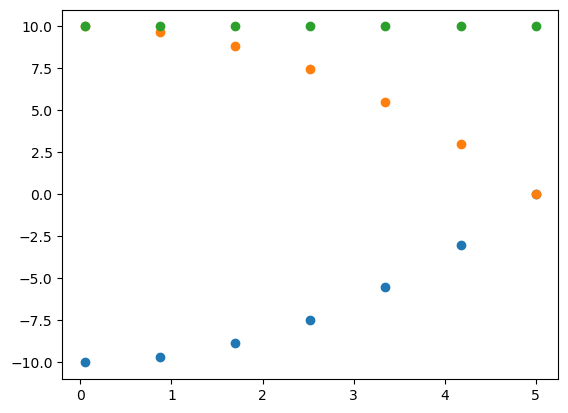

In [2]:
import matplotlib.pyplot as plt
import torch
s=20
r1 = 1/s
r2 = 100/s
a=0.02*s
r1 = float(r1)
r2 = float(r2)
a = float(a)
# super().__init__()
# assert r2 >= r1
# self.r1 = r1
# self.r2 = r2
# self.a = a
# print(r1,r2,a)
# self.name = "Shell.{}".format(name)
# self.geom_node = GeomNode(self.name)
# # 2 paraboloids in column coord
# theta = torch.arange(start=0, end=2 * np.pi, step=np.pi/6)
n_steps_shell = 6
step = (r2 - r1) / n_steps_shell

rho = torch.arange(start=r1, end=r2+step, step=step)
print(rho)
z_2_shift = a * r2 ** 2
x1 =  a * rho ** 2 - z_2_shift
x2 = -  a * rho ** 2 + z_2_shift 
plt.scatter(rho,x1)
plt.scatter(rho,x2)
# plt.scatter(rho,z_2_shift*torch.ones_like(rho))
# self.geom_c1 = uv_curve_surface_lambda(
#     f"{self.name}.1",
#     u=theta,v=rho,
#     is_u_loop=True, is_v_loop=False,
#     x_uv=lambda _theta, _rho: a * _rho ** 2 - z_2_shift,
#     y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
#     z_uv=lambda _theta, _rho: _rho * np.sin(-_theta),
#     # FIXME geom node
# )
# self.geom_c2 = uv_curve_surface_lambda(
#     f"{self.name}.2",
#     u=theta,v=rho,
#     is_u_loop=True, is_v_loop=False,
#     x_uv=lambda _theta, _rho: -  a * _rho ** 2 + z_2_shift,
#     y_uv=lambda _theta, _rho: _rho * np.cos(_theta),
#     z_uv=lambda _theta, _rho: _rho * np.sin(_theta),
#     # FIXME geom node
# )

tensor([0.0500, 0.6687, 1.2875, 1.9062, 2.5250, 3.1437, 3.7625, 4.3812])


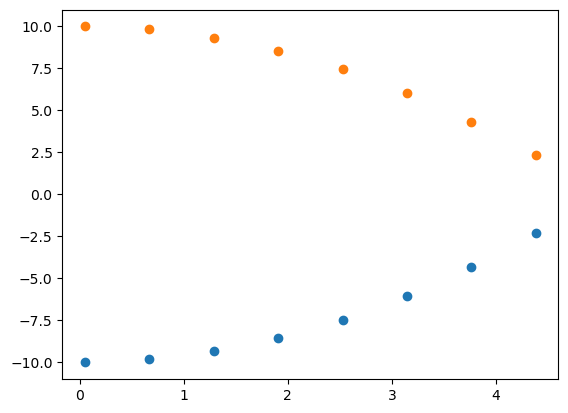

In [7]:
# keel thickness: 1m
# frame thickness: 0.1m
n_steps_frame = 8
step = (r2 - r1) / n_steps_frame
rho = torch.arange(start=r1, end=r2+step, step=step)[:-1]

print(rho)
z_2_shift = a * r2 ** 2
radius = a * rho ** 2 - z_2_shift
x1 =  radius
x2 = -  radius
plt.scatter(rho,x1)
plt.scatter(rho,x2)
# CylinderShape(
#     r = radius,
#     height=1,
    

In [ ]:
r2+step

In [43]:
torch.arange(1,100.1,step=0.1)

tensor([  1.0000,   1.1000,   1.2000,   1.3000,   1.4000,   1.5000,   1.6000,
          1.7000,   1.8000,   1.9000,   2.0000,   2.1000,   2.2000,   2.3000,
          2.4000,   2.5000,   2.6000,   2.7000,   2.8000,   2.9000,   3.0000,
          3.1000,   3.2000,   3.3000,   3.4000,   3.5000,   3.6000,   3.7000,
          3.8000,   3.9000,   4.0000,   4.1000,   4.2000,   4.3000,   4.4000,
          4.5000,   4.6000,   4.7000,   4.8000,   4.9000,   5.0000,   5.1000,
          5.2000,   5.3000,   5.4000,   5.5000,   5.6000,   5.7000,   5.8000,
          5.9000,   6.0000,   6.1000,   6.2000,   6.3000,   6.4000,   6.5000,
          6.6000,   6.7000,   6.8000,   6.9000,   7.0000,   7.1000,   7.2000,
          7.3000,   7.4000,   7.5000,   7.6000,   7.7000,   7.8000,   7.9000,
          8.0000,   8.1000,   8.2000,   8.3000,   8.4000,   8.5000,   8.6000,
          8.7000,   8.8000,   8.9000,   9.0000,   9.1000,   9.2000,   9.3000,
          9.4000,   9.5000,   9.6000,   9.7000,   9.8000,   9.90

In [48]:
step=(r2-r1)/6
torch.arange(start=r1, end=r2+step, step=step)

tensor([ 0.1000,  1.7500,  3.4000,  5.0500,  6.7000,  8.3500, 10.0000])